# Omnipose Segmentation from ImageJ Macro converted image directories

This file is meant to aid in omnipose segmentation in a reproducible and streamlined way to help with automated image analysis especially early QC to adjust experimental and imaging parameters as needed to optimize S/N for the experiment. 

#### Import Necessary packages and Functions

## Running Omnipose for Segmentation

Here is the incorporation into the omnipose script

### Importing the images and QC to check images match expectations

### Collecting all the tiff files for omnipose


### Segmentation


## Statistical Analysis

Now that I have all of the images post mask processing in an organized format I can look into reading them into the memory and performing statistics on them. 


### Intializing Functions for Analysis and Metadata Assignments


In [13]:
import pandas as pd
import numpy as np
import scipy.stats
import ast 
import re
from skimage.io import imread, imsave
from skimage import img_as_uint 
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import time
from tifffile import TiffFile, imwrite
from tifffile import TiffFile, imsave
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt


# Function to calculate image statistics
def calculate_image_stats(image_path):
    # Read the image
    image = imread(image_path)

    # Check if the image is empty or all zeros
    if image.size == 0 or np.all(image == 0):
        print(f"Warning: The image at {image_path} is empty or all zeros.")
        return None  # Return None to indicate that stats could not be calculated
    
    
    # Filter out the zero pixels
    image = image[image > 0]
    # Initialize a dictionary to store the statistics
    stats_dict = {}
    # Calculate statistics
    stats_dict['mean'] = np.mean(image)
    stats_dict['median'] = np.median(image)
    stats_dict['max'] = np.max(image)
    stats_dict['min'] = np.min(image)
    stats_dict['std_dev'] = np.std(image)
    stats_dict['skewness'] = scipy.stats.skew(image)
    stats_dict['kurtosis'] = scipy.stats.kurtosis(image)
    stats_dict['pixel_count'] = len(image)
    stats_dict['area_covered'] = (len(image)/262144)
    # Extract easy Metadata

    # Extract metadata from the file path
    p = Path(image_path)

    ### From the deepest file level
    try:
        split_stem = p.stem.split('_')
        frame = split_stem[1]
        z_stack = split_stem[3]
        channel = split_stem[5]
        stats_dict['frame'] = frame
        stats_dict['z_stack'] = z_stack
        stats_dict['channel'] = channel
        stats_dict['full_filepath'] = str(p)  # Adding full file path
    except IndexError:
        print(f"Failed to extract frame, z_stack, channel from {p.stem}")

    ### From the directory structure
    root_parts = root.split('\\')
    try:
        condition = root_parts[9].split('_')[-1].split('.')[0]  # 'inf' or 'uninf'
        strain = root_parts[9].split('_')[1]  # 10min, 20min, etc.
        time = root_parts[9].split('_')[2].split('.')[0]  # LZ222##
        stats_dict['condition'] = condition
        stats_dict['time'] = time
        stats_dict['strain'] = strain
    except IndexError:
        print(f"Failed to extract condition, time, strain from {root}")

    # Extract 'image_type' from the directory name
    directory_name = os.path.dirname(image_path)  # Get the directory
    image_type = os.path.basename(directory_name)  # Extract the last part of the directory
    
    # Convert 'background_only' or 'cell_only' to 'background' or 'cell'
    if 'background_only' in image_type:
        image_type = 'background'
    elif 'cell_only' in image_type:
        image_type = 'cell'
    else:
        image_type = 'unknown'
    
    stats_dict['image_type'] = image_type

    biorep = '1'  # All 1 in this case
    stats_dict['biorep'] = biorep

    return stats_dict


# Function to extract metadata for channel naming
def extract_metadata_channel(root_dir):
    metadata_list = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.ome.tiff') or file.endswith('.ome.tif'):
                full_path = os.path.join(root, file)
                reader = OmeTiffReader(full_path)
                ome_metadata = reader.ome_metadata
                channel_names = [channel.name for channel in ome_metadata.images[0].pixels.channels]
                metadata_list.append({'full_filepath': full_path, 'channel_names': channel_names})
    return pd.DataFrame(metadata_list)

#import re  # Importing the regular expression library

def merge_metadata(df, df_metadata, channel_map=None):
    
    """
    Merge metadata into the main dataframe based on matching 'full_filepath'.
    A new column 'signal' is created based on the corresponding 'channel_names' from df_metadata.
    Optionally, a channel_map can be provided to rename the channels.
    
    Parameters:
    df (DataFrame): The main dataframe containing various columns including 'full_filepath' and 'channel'.
    df_metadata (DataFrame): Metadata dataframe containing 'full_filepath' and 'channel_names'.
    channel_map (dict, optional): A dictionary to map original channel names to new names.
    
    """
    # Initialize an empty list to hold the new 'signal' column values
    signal_list = [None] * len(df)
    
    # Loop through each row in df
    for i, row in df.iterrows():
        matched = False  # Variable to indicate if a match was found
        # Loop through each row in df_metadata
        for j, row_metadata in df_metadata.iterrows():
            # Separate the root from the filename using rsplit
            root_metadata = row_metadata['full_filepath'].rsplit('\\', 1)[0]
            
            # Create a regex pattern for the root
            pattern = re.compile(re.escape(root_metadata))
            
            # Use regex to find if the root exists in 'full_filepath' of df
            if pattern.search(row['full_filepath']):
                matched = True  # A match was found, set the variable to True
                # Check if the 'channel' value can be converted to an integer
                try:
                    channel_index = int(row['channel'])
                except ValueError:
                    print(f"Warning: Could not convert channel value {row['channel']} to integer at row {i}.")
                    continue  # Skip this row and continue with the next one

                # Check the type of channel_names and convert if necessary
                if isinstance(row_metadata['channel_names'], str):
                    try:
                        channel_names = ast.literal_eval(row_metadata['channel_names'])
                    except ValueError as e:
                        print(f"Failed to parse channel_names at row {j} in df_metadata: {e}")
                        continue
                else:
                    channel_names = row_metadata['channel_names']


                    # Check if channel_index is within the range of channel_names
                    if 0 <= channel_index < len(channel_names):
                        signal_name = channel_names[channel_index]
                        
                        # Apply channel_map if provided
                        if channel_map and signal_name in channel_map:
                            signal_name = channel_map[signal_name]
                        
                        signal_list[i] = signal_name
                    else:
                        print(f"Warning: channel_index {channel_index} is out of range for channel_names {channel_names} at row {i}.")
                    break  # No need to continue checking for this row, move on to the next one
                if not matched:
                    print(f"Warning: No metadata match found for row {i} with filepath {row['full_filepath']}.")
        # Add the new 'signal' column to df
        df['signal'] = signal_list




### Statistics and Metadata Assignment Calc

### Exploring the data from the images

##### Background-only EDA 

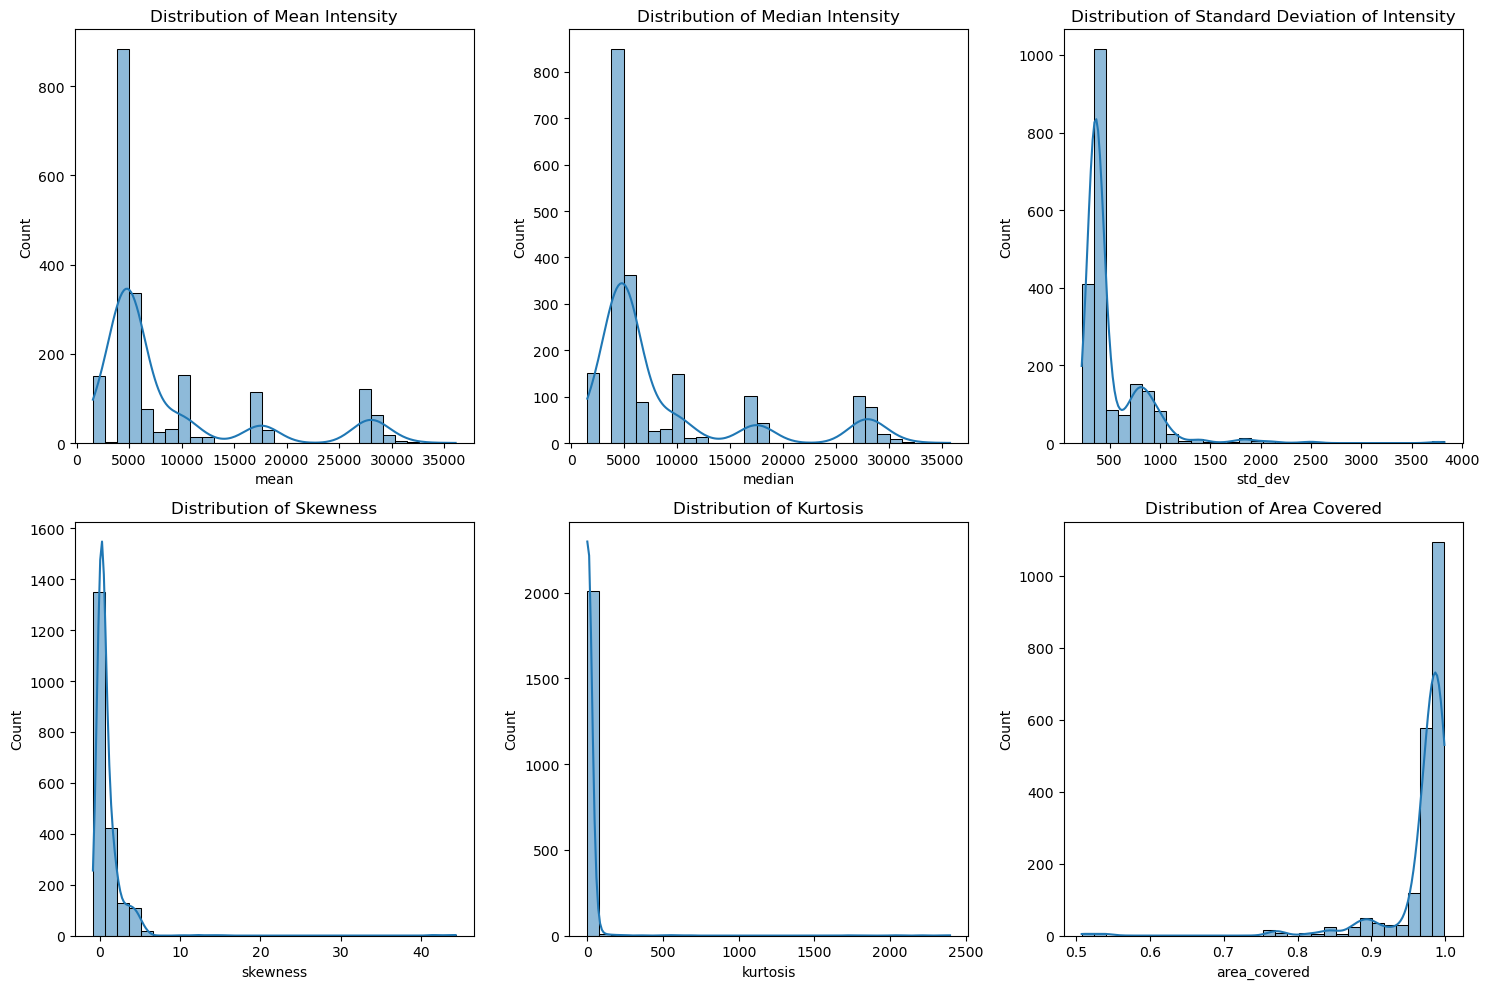

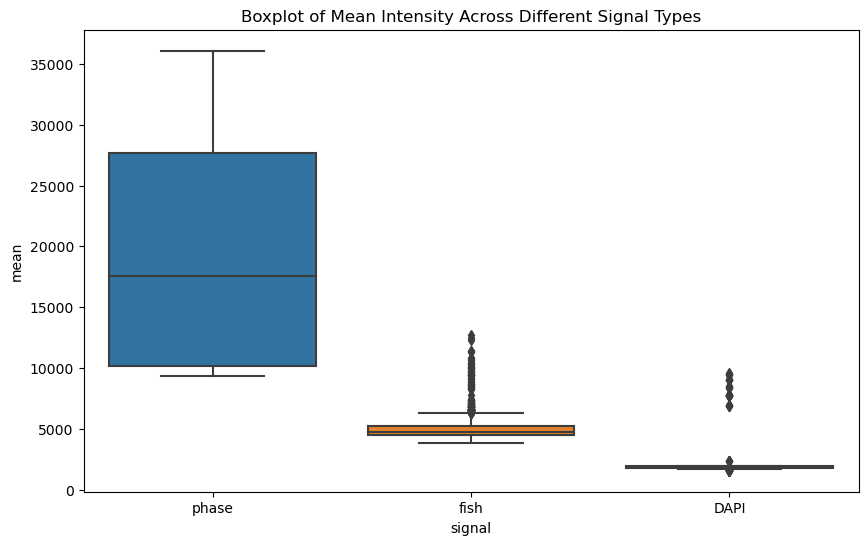

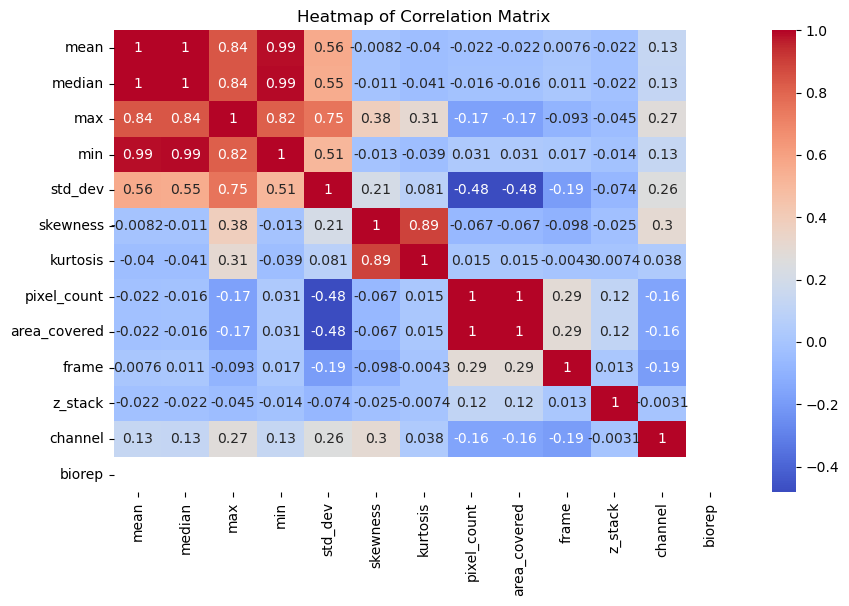

,mean,median,max,min,std_dev,skewness,kurtosis,pixel_count,area_covered,frame,z_stack,channel,biorep
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.0
mean,8554.080616,8511.137390,14160.559863,6129.919529,524.538735,1.004293,13.828495,254049.184495,0.969121,9.177134,1.961727,0.430324,1.0
std,7648.247665,7629.639229,11165.054844,5998.497979,344.878219,2.494418,120.216600,14330.091269,0.054665,6.969287,1.345371,0.649612,0.0
min,1552.652562,1532.000000,5299.000000,436.000000,222.069249,-0.843024,-0.371977,133160.000000,0.507965,0.000000,0.000000,0.000000,1.0
25%,4495.394304,4486.250000,6909.250000,3049.000000,346.102319,0.134343,0.097672,254974.000000,0.972649,3.000000,1.000000,0.000000,1.0
50%,4983.619698,4972.000000,8398.500000,3447.000000,374.534037,0.227830,0.526921,257798.000000,0.983421,8.000000,2.000000,0.000000,1.0
75%,9716.413102,9664.750000,17854.750000,5956.500000,605.283651,1.187636,4.872123,260158.000000,0.992424,13.750000,3.000000,1.000000,1.0
max,36085.468958,35748.000000,65535.000000,28961.000000,3823.350783,44.268679,2396.380266,261805.000000,0.998707,33.000000,4.000000,2.000000,1.0


In [14]:
import seaborn as sns


# Root directory
root_dir = r'C:\Users\mattt\Documents\Omni\image_post_omni_biorep1_curated'  #this would be a directory where your biorep level folder is stored

# Specify the filename
filename = 'df.csv'

# Create the full path by joining root_dir and filename
full_path = os.path.join(root_dir, filename)

# Load the DataFrame from the CSV file
df = pd.read_csv(full_path)

# Filter the DataFrame to include only 'background only' images
df_background_only = df[df['image_type'] == 'background']

# Perform EDA on background-only DataFrame

# 1. Summary statistics
summary_stats = df_background_only.describe()

# 2. Histograms for some of the numerical columns like 'mean', 'median', 'std_dev', etc.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(df_background_only['mean'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Mean Intensity')
sns.histplot(df_background_only['median'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Median Intensity')
sns.histplot(df_background_only['std_dev'], bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Standard Deviation of Intensity')
sns.histplot(df_background_only['skewness'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Skewness')
sns.histplot(df_background_only['kurtosis'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Kurtosis')
sns.histplot(df_background_only['area_covered'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Area Covered')
plt.tight_layout()
plt.show()

# 3. Boxplots to examine the distribution of 'mean' across different 'signal' types
plt.figure(figsize=(10, 6))
sns.boxplot(x='signal', y='mean', data=df_background_only)
plt.title('Boxplot of Mean Intensity Across Different Signal Types')
plt.show()

# 4. Correlation matrix between numerical variables
correlation_matrix = df_background_only.corr()

# 5. Heatmap for the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

summary_stats


### Separating Out the Different Channels

### Observations and Interpretations

#### DAPI
1. **Mean Intensity**: The mean intensity for DAPI ranges from around 1553 to 9621 with a median value of approximately 1852. This suggests that DAPI staining varies across the images but is generally on the lower end of the intensity scale.
2. **Standard Deviation**: The standard deviation ranges from about 222 to 3823, indicating varied levels of heterogeneity in DAPI signal across the images.
3. **Skewness**: The distribution of skewness ranges from about 1.85 to 5.84, which indicates a positive skew (tail on the right-hand side) in the data distribution.
4. **Kurtosis**: The kurtosis ranges from about 7.91 to 71.16, suggesting that the distribution has heavy tails and is leptokurtic.

#### FISH
1. **Mean Intensity**: The mean intensity for FISH images ranges from around 4796 to 12673 with a median value of approximately 5939. This is considerably higher than DAPI, as expected.
2. **Standard Deviation**: The standard deviation ranges from about 354 to 1125, showing less variability in the FISH signals compared to DAPI.
3. **Skewness**: The skewness is relatively low, ranging from 0.088 to 15.43, suggesting that the FISH data is not as skewed as the DAPI data.
4. **Kurtosis**: The kurtosis for FISH is notably high, with a range from about 0.0006 to 1722.4. This indicates a leptokurtic distribution, similar to DAPI.

### Conclusions
- DAPI signals are generally lower in intensity but have a higher standard deviation, suggesting more variability in the signals.
- FISH signals are higher in intensity and are less variable compared to DAPI.
- Both DAPI and FISH show leptokurtic distributions, meaning they have heavy tails.
- The skewness in DAPI is notably higher, suggesting that the data is positively skewed.

Would you like to delve into any specific aspect further?

### Now Comparing with cells_only

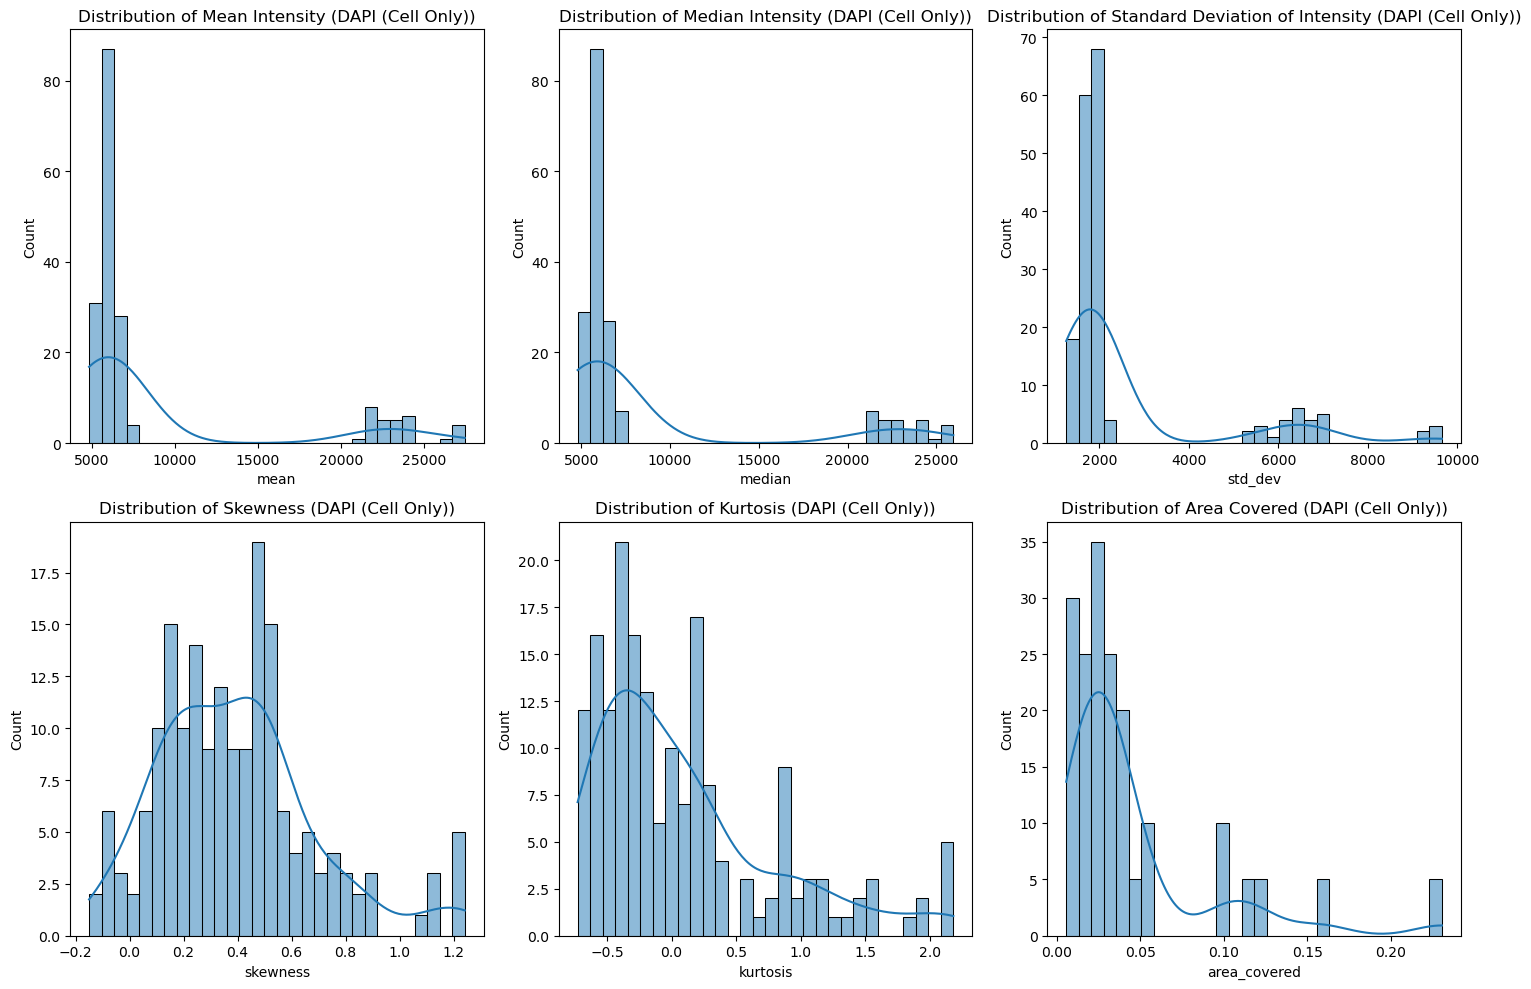

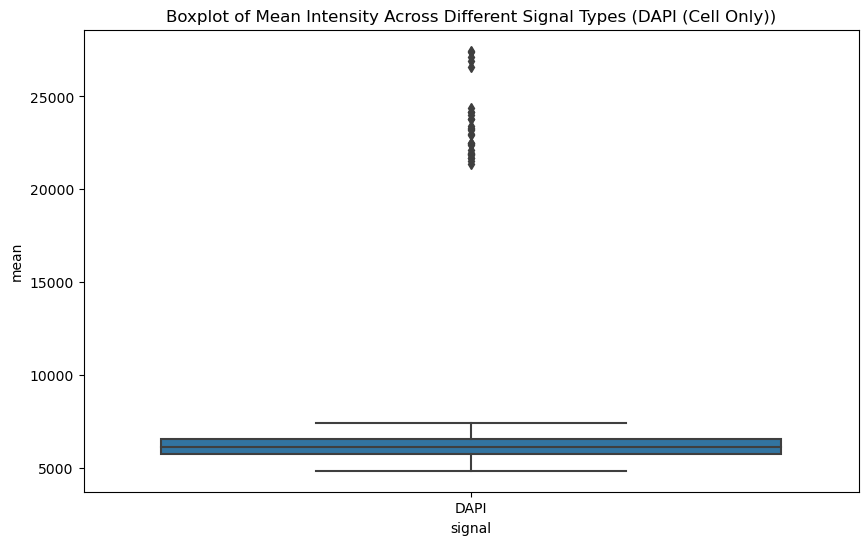

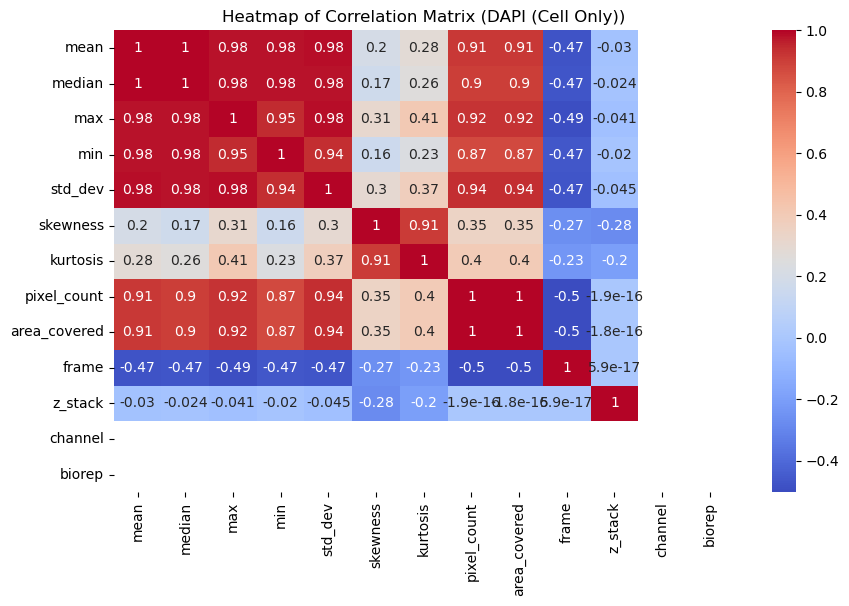

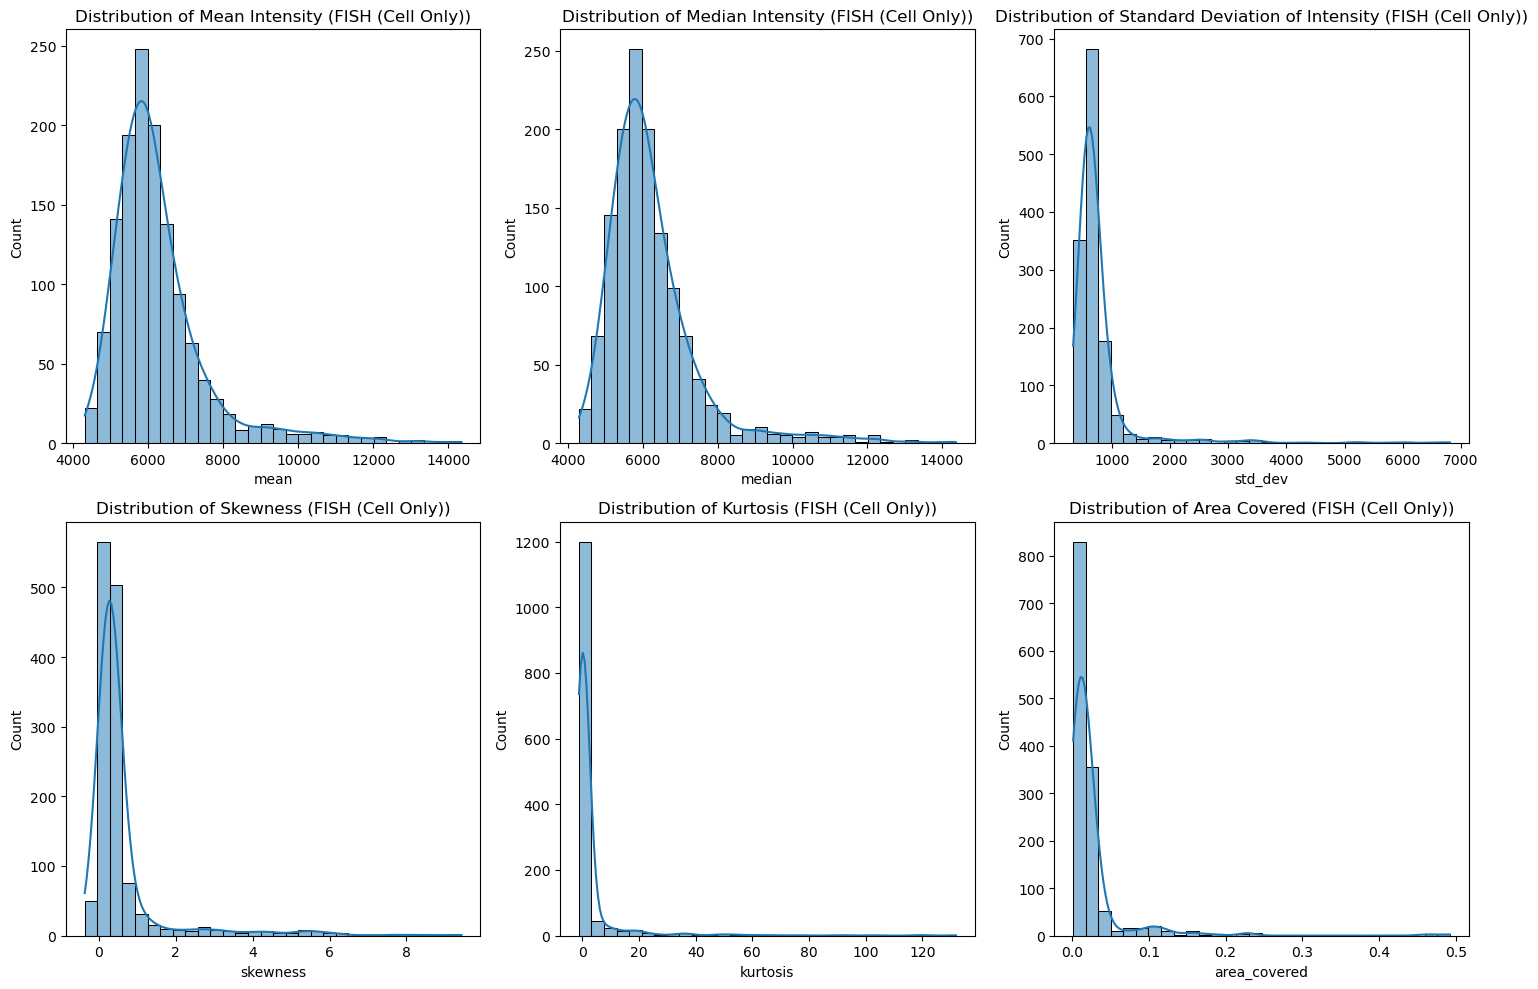

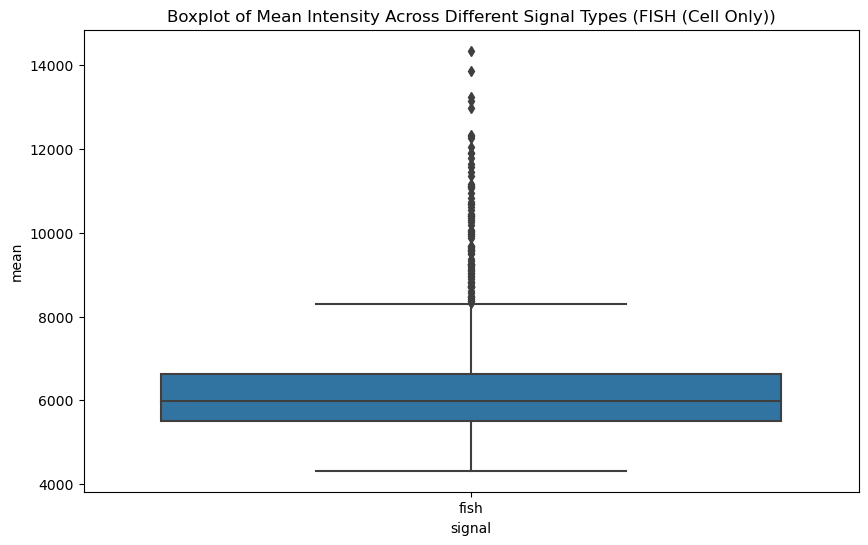

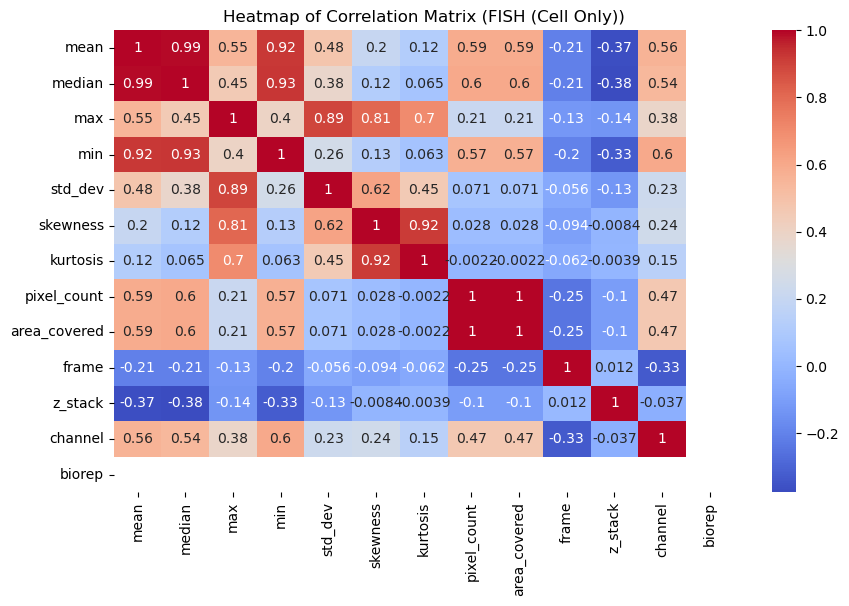

In [15]:
# Filter the DataFrame to include only 'cell_only' images
df_cell_only = df[df['image_type'] == 'cell']

# Prepare DataFrames for DAPI and FISH channels for 'cell_only' images
df_dapi_cell = df_cell_only[df_cell_only['signal'].str.lower() == 'dapi']
df_fish_cell = df_cell_only[df_cell_only['signal'].str.lower() == 'fish']

# Initialize a list to store summary statistics
summary_stats_cell = []

# Function to perform EDA and plot
def perform_eda(df, title_prefix):
    # Summary statistics
    summary_stats = df.describe()
    summary_stats_cell.append({f"{title_prefix}_stats": summary_stats})
    
    # Histograms for some of the numerical columns like 'mean', 'median', 'std_dev', etc.
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    sns.histplot(df['mean'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'Distribution of Mean Intensity ({title_prefix})')
    sns.histplot(df['median'], bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title(f'Distribution of Median Intensity ({title_prefix})')
    sns.histplot(df['std_dev'], bins=30, kde=True, ax=axes[0, 2])
    axes[0, 2].set_title(f'Distribution of Standard Deviation of Intensity ({title_prefix})')
    sns.histplot(df['skewness'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'Distribution of Skewness ({title_prefix})')
    sns.histplot(df['kurtosis'], bins=30, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'Distribution of Kurtosis ({title_prefix})')
    sns.histplot(df['area_covered'], bins=30, kde=True, ax=axes[1, 2])
    axes[1, 2].set_title(f'Distribution of Area Covered ({title_prefix})')
    plt.tight_layout()
    plt.show()

    # Boxplots to examine the distribution of 'mean' across different 'signal' types
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='signal', y='mean', data=df)
    plt.title(f'Boxplot of Mean Intensity Across Different Signal Types ({title_prefix})')
    plt.show()

    # Correlation matrix between numerical variables
    correlation_matrix = df.corr()

    # Heatmap for the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Heatmap of Correlation Matrix ({title_prefix})')
    plt.show()

# Perform EDA for DAPI in 'cell_only' images
perform_eda(df_dapi_cell, "DAPI (Cell Only)")

# Perform EDA for FISH in 'cell_only' images
perform_eda(df_fish_cell, "FISH (Cell Only)")


###  Cell Only FISH Signal


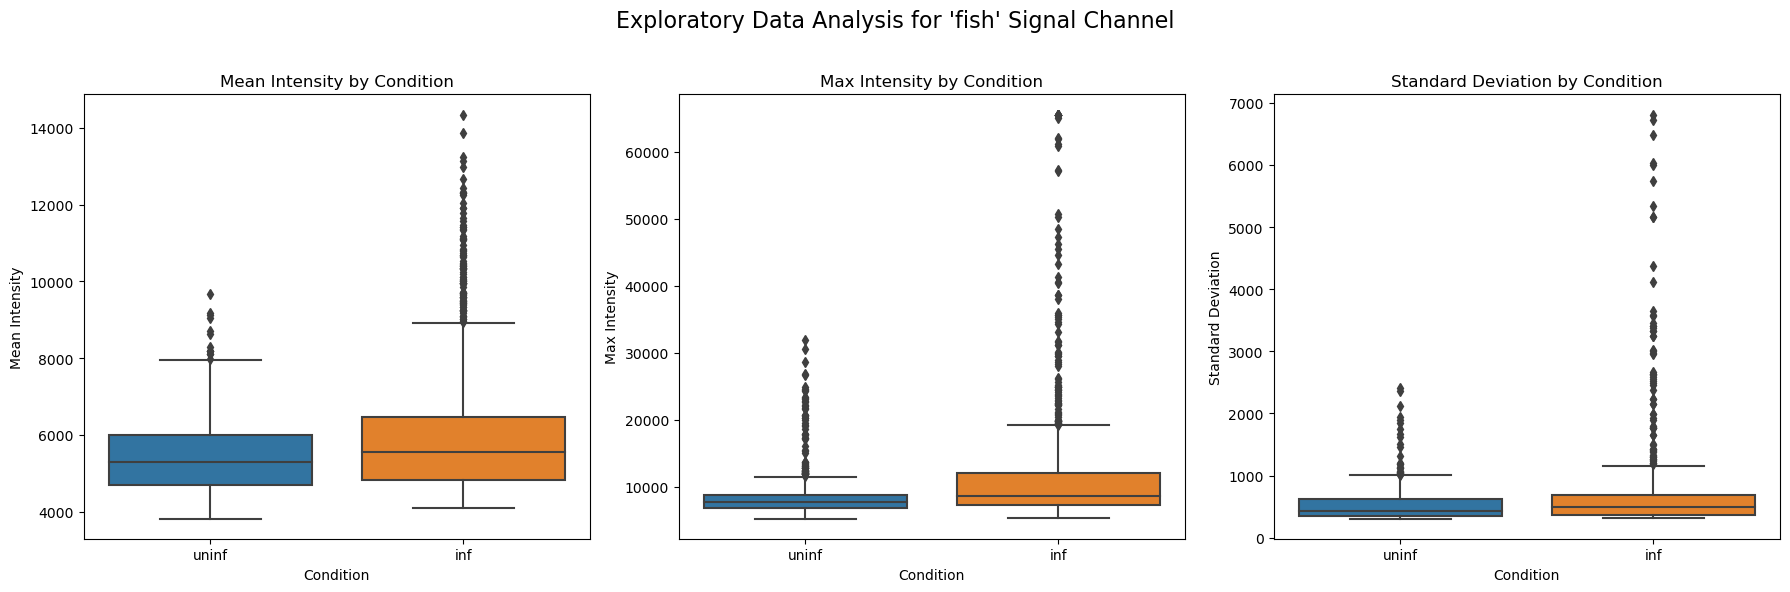

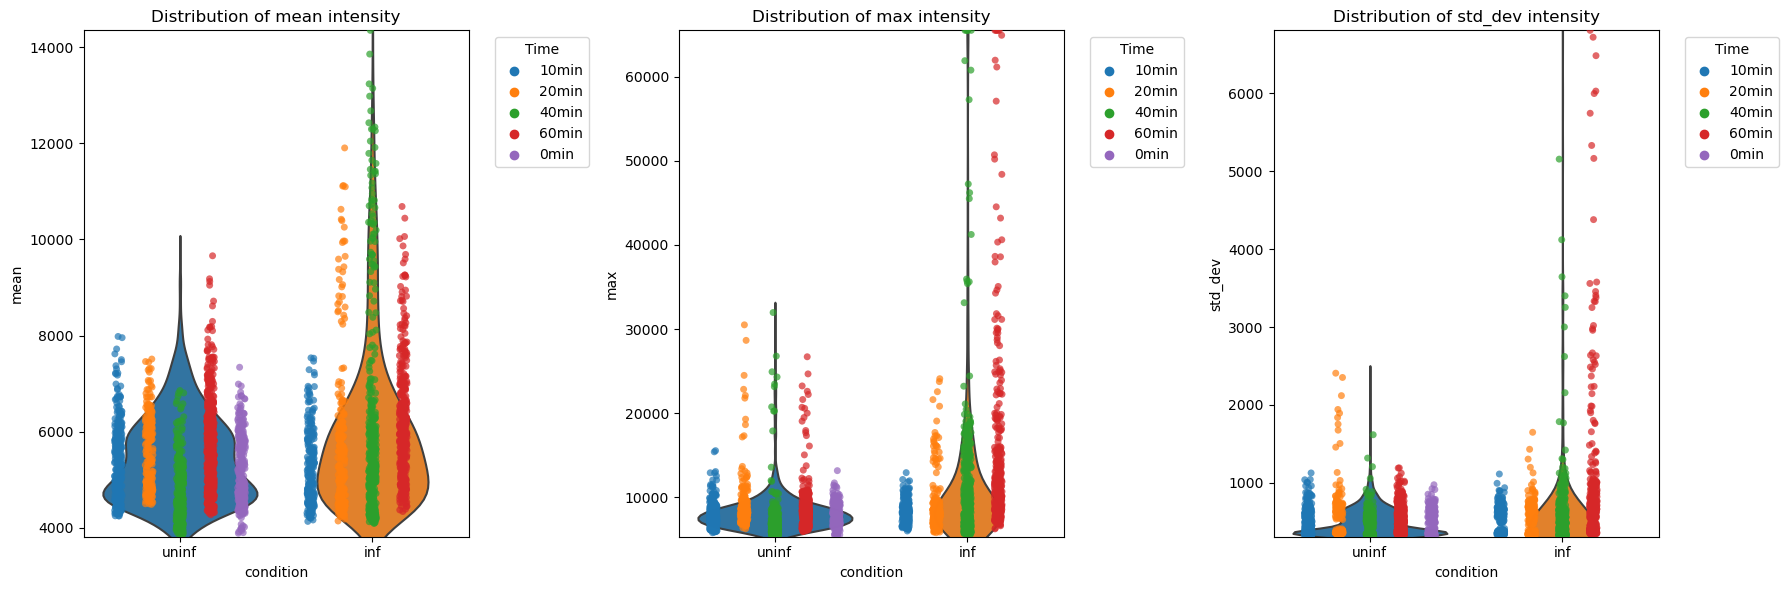

In [16]:
# Replace 'crop' with 'inf' in the 'condition' column
df['condition'] = df['condition'].replace('crop', 'inf')

# Filter the DataFrame to only include rows where 'signal' is 'fish'
df_fish = df[df['signal'] == 'fish']

# Create boxplots for mean_intensity, max_intensity, and std_dev, grouped by 'condition'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Exploratory Data Analysis for 'fish' Signal Channel", fontsize=16)

sns.boxplot(x='condition', y='mean', data=df_fish, ax=axes[0])
axes[0].set_title('Mean Intensity by Condition')
axes[0].set_xlabel('Condition')
axes[0].set_ylabel('Mean Intensity')

sns.boxplot(x='condition', y='max', data=df_fish, ax=axes[1])
axes[1].set_title('Max Intensity by Condition')
axes[1].set_xlabel('Condition')
axes[1].set_ylabel('Max Intensity')

sns.boxplot(x='condition', y='std_dev', data=df_fish, ax=axes[2])
axes[2].set_title('Standard Deviation by Condition')
axes[2].set_xlabel('Condition')
axes[2].set_ylabel('Standard Deviation')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Generate the dynamic y-axis plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = ['mean', 'max', 'std_dev']

for ax, metric in zip(axes, metrics):
    sns.violinplot(x='condition', y=metric, data=df_fish, inner=None, ax=ax)
    sns.stripplot(x='condition', y=metric, data=df_fish, hue='time', dodge=True, marker='o', alpha=0.7, ax=ax)
    ax.set_title(f'Distribution of {metric} intensity')
    ax.set_ylim(df_fish[metric].min(), df_fish[metric].max())  # Dynamic y-axis
    ax.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### Adjusting the plot to Stratify over zstack

This will check if theres any zstack artifact that may lead to artifacts determined by the position of the foci

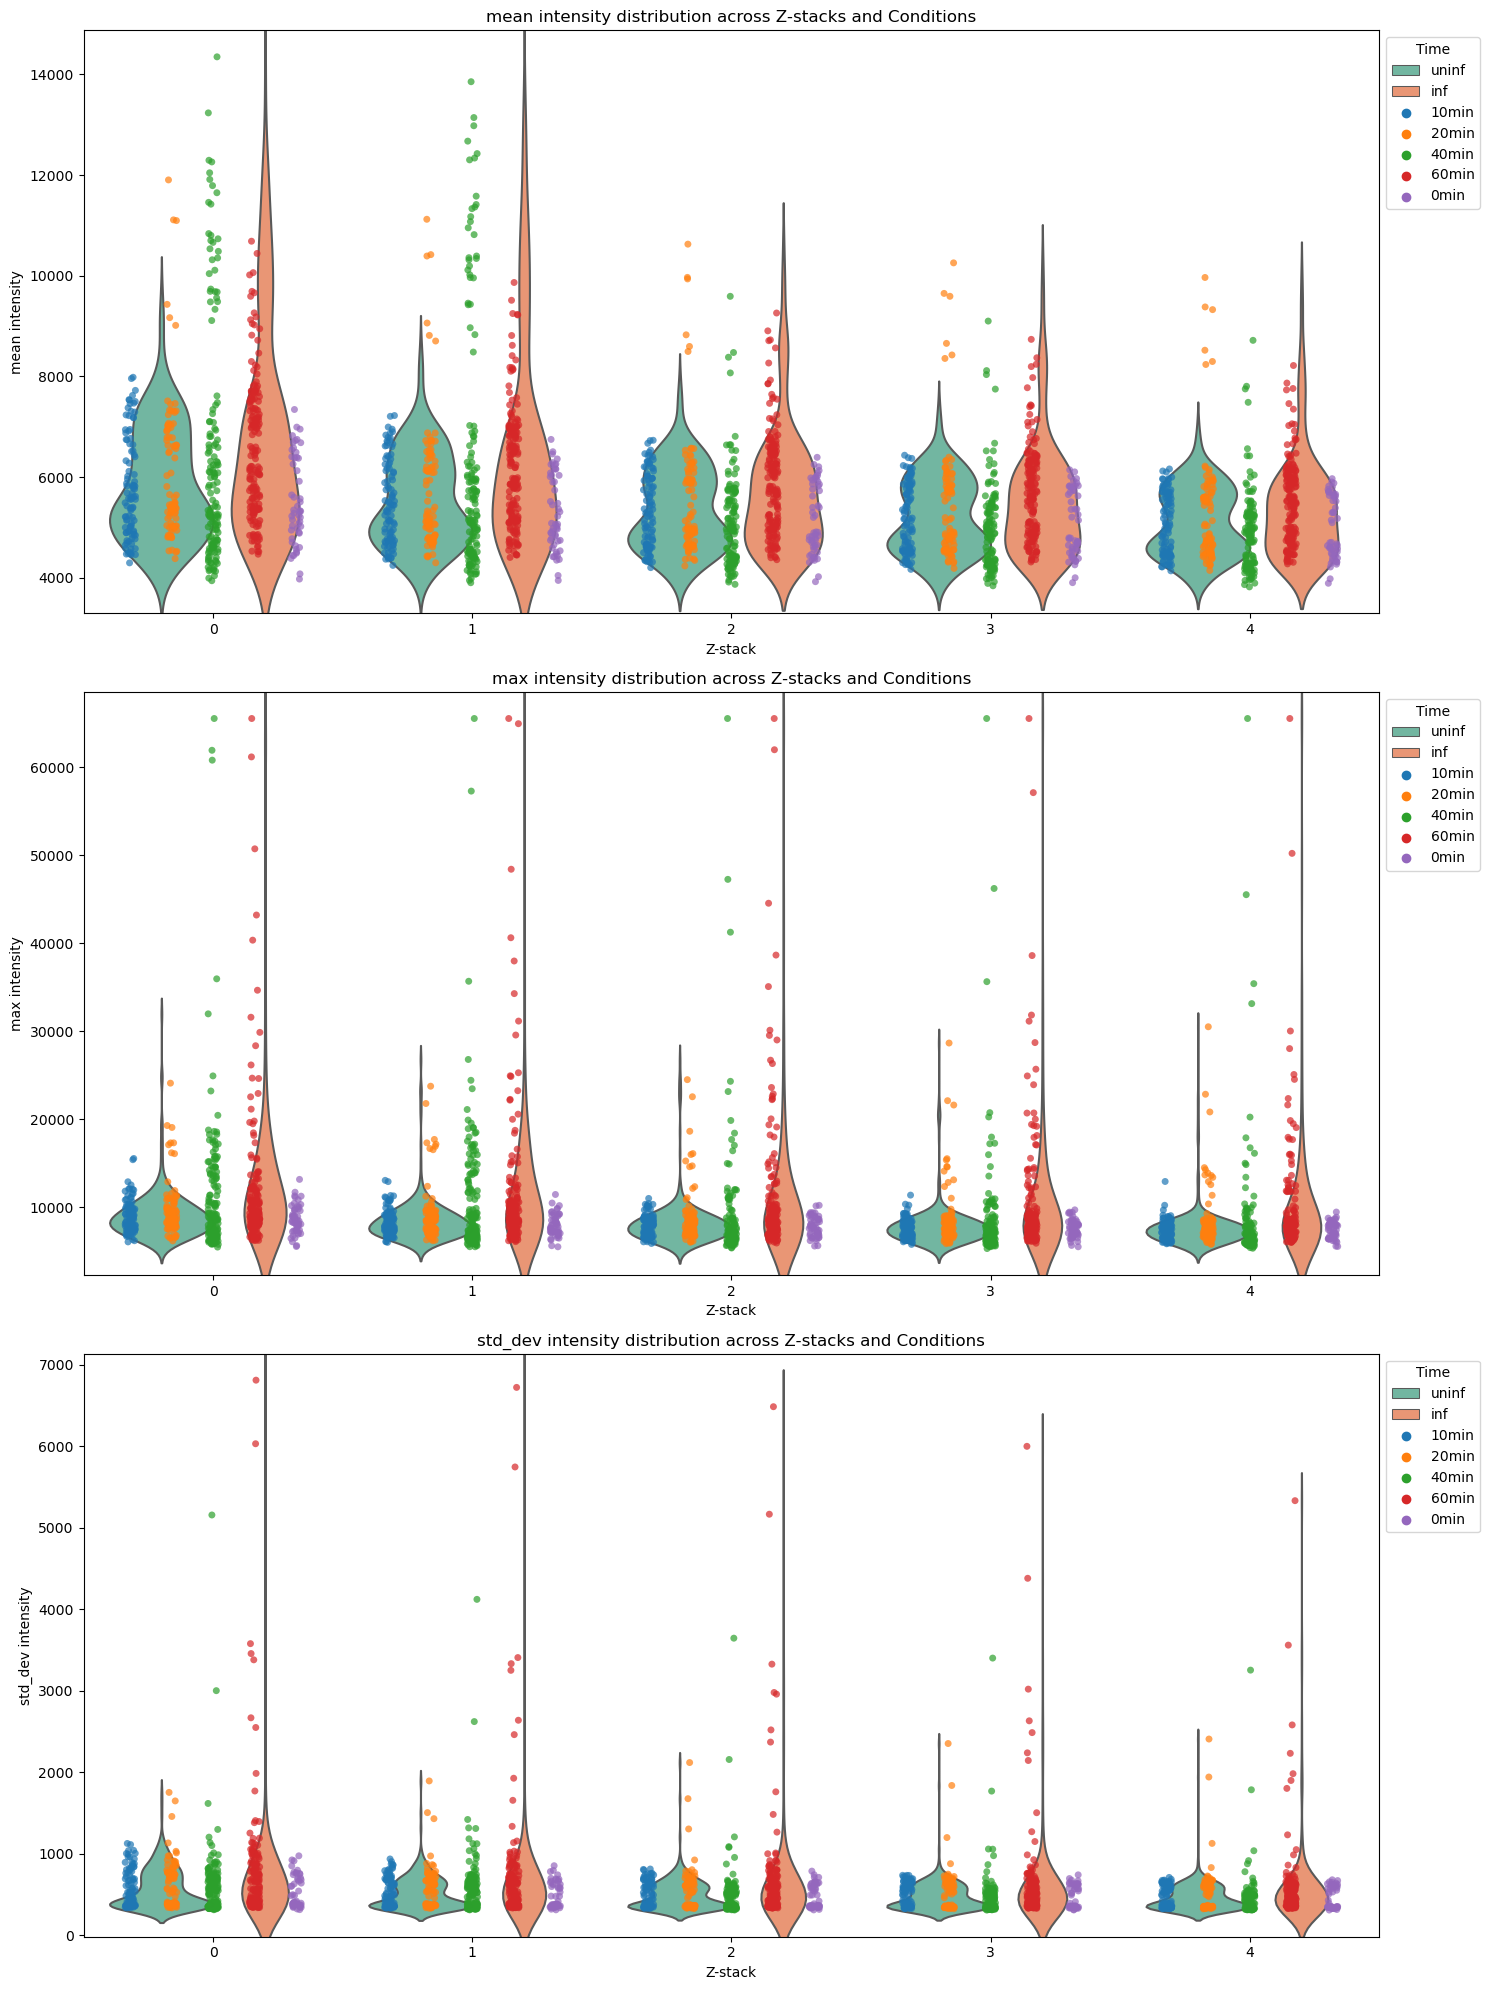

In [17]:
# Create violin plots separated by condition and stratified by z-stack, with datapoints colored by time
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

metrics = ['mean', 'max', 'std_dev']
for ax, metric in zip(axes, metrics):
    sns.violinplot(data=df_fish, x='z_stack', y=metric, hue='condition', inner=None, ax=ax, palette="Set2")
    sns.stripplot(data=df_fish, x='z_stack', y=metric, hue='time', dodge=True, marker='o', alpha=0.7, ax=ax)
    
    ax.set_title(f'{metric} intensity distribution across Z-stacks and Conditions')
    ax.set_ylabel(f'{metric} intensity')
    ax.set_xlabel('Z-stack')
    ax.legend(title='Time', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

c:\Users\Nikon\anaconda3\envs\omnipose\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


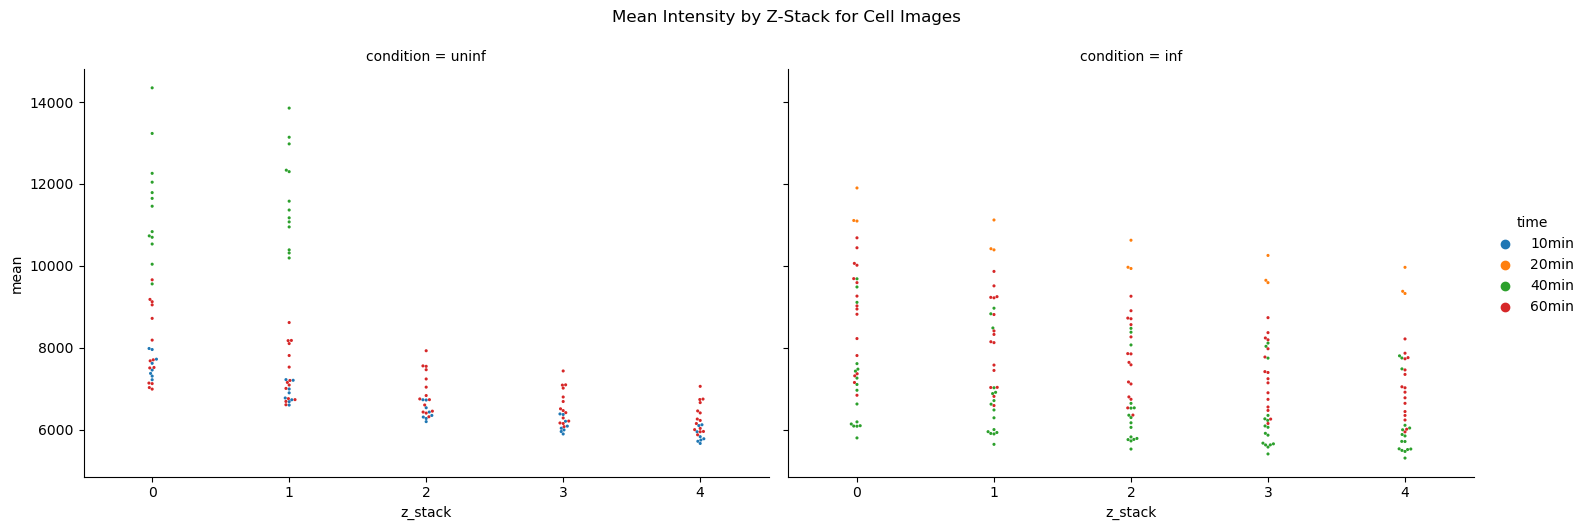

In [25]:
# Filter the DataFrame to include only 'cell' images
df_cell_only_fish = df[(df['image_type'] == 'cell') & (df['signal'] == 'fish')]

# Create the catplot for mean intensity across different Z-stacks, colored by time, and faceted by condition
sns.catplot(
    data=df_cell_only_fish, kind="swarm",
    x="z_stack", y="mean", hue="time", col="condition",
    aspect=1.5, s=5
)
plt.suptitle('Mean Intensity by Z-Stack for Cell Images', y=1.05)
plt.show()

c:\Users\mattt\anaconda3\envs\stat_analysis\lib\site-packages\seaborn\categorical.py:299: UserWarning: You passed a edgecolor/edgecolors ('gray') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
c:\Users\mattt\anaconda3\envs\stat_analysis\lib\site-packages\seaborn\categorical.py:299: UserWarning: You passed a edgecolor/edgecolors ('gray') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)


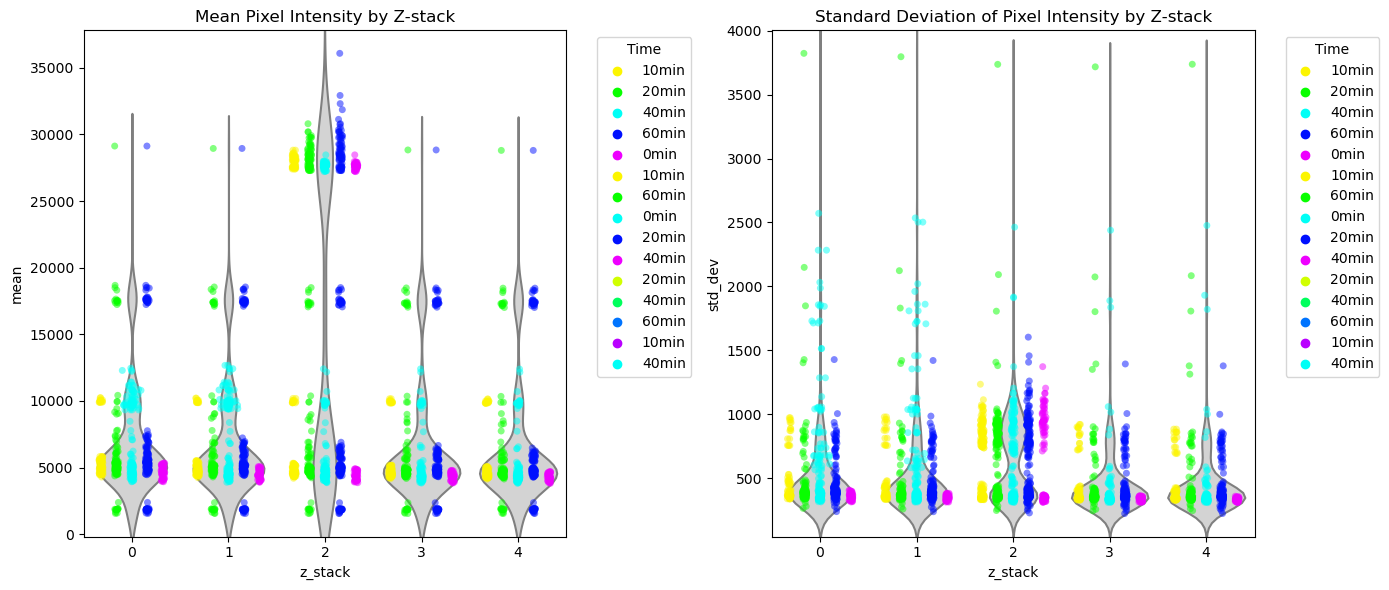

In [18]:
#### Violin Plots Labeled by condition and time groupings 

# Plotting the violin plots with individual data points colored by 'time' and marker style based on 'condition'
plt.figure(figsize=(14, 6))

# Plot for mean
plt.subplot(1, 2, 1)
sns.violinplot(x='z_stack', y='mean', data=df_background_only, inner=None, color='lightgray')
sns.stripplot(x='z_stack', y='mean', data=df_background_only, hue='time', dodge=True,
              marker='o', alpha=0.5, edgecolor='gray',
              palette=sns.color_palette("hsv", len(df_background_only['time'].unique())))
# Modify markers based on condition
for condition in df_background_only['condition'].unique():
    subset = df_background_only[df_background_only['condition'] == condition]
    marker = 'x' if condition == 'inf' else 'o'
    sns.stripplot(x='z_stack', y='mean', data=subset, hue='time', dodge=True, 
                  marker=marker, alpha=0.5, edgecolor='gray',
                  palette=sns.color_palette("hsv", len(subset['time'].unique())))

plt.title('Mean Pixel Intensity by Z-stack')
plt.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for standard deviation
plt.subplot(1, 2, 2)
sns.violinplot(x='z_stack', y='std_dev', data=df_background_only, inner=None, color='lightgray')
sns.stripplot(x='z_stack', y='std_dev', data=df_background_only, hue='time', dodge=True,
              marker='o', alpha=0.5, edgecolor='gray',
              palette=sns.color_palette("hsv", len(df_background_only['time'].unique())))
# Modify markers based on condition
for condition in df_background_only['condition'].unique():
    subset = df_background_only[df_background_only['condition'] == condition]
    marker = 'x' if condition == 'inf' else 'o'
    sns.stripplot(x='z_stack', y='std_dev', data=subset, hue='time', dodge=True, 
                  marker=marker, alpha=0.5, edgecolor='gray',
                  palette=sns.color_palette("hsv", len(subset['time'].unique())))

plt.title('Standard Deviation of Pixel Intensity by Z-stack')
plt.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



### Observations of VAriation by ZStack:

1. **Mean Pixel Intensity**: The mean pixel intensity seems to vary between Z-stacks, although not dramatically. The median pixel intensity appears higher for Z0 and Z1 compared to other Z-stacks, which might suggest that these layers are brighter. This could potentially be related to the hypothesis regarding bleaching, as these are the initial Z-stacks captured.

2. **Standard Deviation of Pixel Intensity**: The standard deviation also varies across Z-stacks. Interestingly, the standard deviation seems to be higher for Z0 and Z1, which could imply that these layers have more variability in pixel intensities.

These observations could indeed support the hypothesis that there is some bleaching effect as you go deeper into the Z-stacks. This is especially evident in the higher mean and standard deviation values for the initial Z-stacks (Z0, Z1) compared to the later ones. 

Would you like to proceed with more specific analyses or discuss these findings in greater detail?

In [43]:
## Here is my current script for analyzing the data coming out of the microbeJ program. Specifically still in the data exploration step and extraction the relevant measurements etc. 


# Load the data from the CSV file
file_path = r"C:\Users\mattt\Documents\Omni\Arihan_MicrobeJ_dfs\data1.csv"
data = pd.read_csv(file_path)

# Check the structure of the dataset (rows and columns)
data_shape = data.shape

# Identify the different data types (classes) present in each column
data_types = data.dtypes

# Calculate the number of unique values in each column, excluding the header
unique_values_per_column = data.nunique()

# Organizing the information into a dataframe for better readability
data_structure_info = pd.DataFrame({
    'Data Types': data_types,
    'Unique Values': unique_values_per_column
})

print(data_shape, data_structure_info)

# Checking for columns with 0 unique values to see if they contain only NaNs or a constant value
empty_or_constant_columns = data.loc[:, data.nunique() == 0]

# Checking for any missing values across the dataset
missing_values = data.isnull().sum()

# Checking for any values that are exactly 0 across the dataset
zero_values = (data == 0).sum()

# Combine the information into a dataframe for better readability
missing_zero_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Zero Values': zero_values
})

print(empty_or_constant_columns, missing_zero_info)


# Making of the subset of the data only pulling possible useful varaibles

# Creating a subset of the data with the specified columns
subset_columns = [
    'NAME.id', 'NAME.name', 'EXPERIMENT.count', 'IMAGE.meta', 'IMAGE.name', 
    'INTENSITY.ch1', 'INTENSITY.ch2', 'LOCATION', 'LOCATION.center', 
    'LOCATION.dist', 'LOCATION.half', 'LOCATION.pole', 'LOCATION.side', 'LOCATION.x', 
    'LOCATION.y', 'MAXIMA', 'MAXIMA.Maxima1', 'MAXIMA.count', 'MEDIAL', 'POSITION', 
    'POSITION.channel', 'POSITION.frame', 'POSITION.position', 'POSITION.slice', 
    'PROFILE_MEDIAL', 'SHAPE', 'SHAPE.angularity', 'SHAPE.area', 'SHAPE.aspectRatio', 
    'SHAPE.circularity', 'SHAPE.curvature', 'SHAPE.feret', 'SHAPE.length', 
    'SHAPE.morphology', 'SHAPE.orientation', 'SHAPE.perimeter', 'SHAPE.pole', 
    'SHAPE.roundness', 'SHAPE.sinuosity', 'SHAPE.solidity', 'SHAPE.width', 'ZSCORE'
]

# Define the parsing function for IMAGE.meta column
def parse_image_meta(image_meta):
    # Extract the Z stack level
    z_stack_match = re.search(r'z:(\d+)/(\d+)', image_meta)
    z_stack = z_stack_match.group(1) if z_stack_match else None

    # Extract other details from the metadata as needed
    # (e.g., channel, time, etc., depending on the format of your metadata)

    return z_stack

# Define a function to parse the 'IMAGE.name' column and extract the specified components
def parse_image_name(image_name):
    # Parse the date, strain, time, condition, and frame number
    date = image_name[:8]
    strain_match = re.search(r'(LZ\d+)', image_name)
    strain = strain_match.group(1) if strain_match else None
    time_match = re.search(r'(\d+)min', image_name)
    time = int(time_match.group(1)) if time_match else None
    cond_match = re.search(r'min_([a-zA-Z]+)', image_name)
    cond = cond_match.group(1) if cond_match else None
    frame_match = re.search(r'T=(\d+)', image_name)
    frame = int(frame_match.group(1)) if frame_match else None
    
    return date, strain, time, cond, frame

# Use .loc to ensure the operation is done on the original DataFrame
data_subset = data[subset_columns].copy()

# Apply the parsing functions to the relevant columns and create new columns
data_subset['z_stack'] = data_subset['IMAGE.meta'].apply(parse_image_meta)
data_subset[['date', 'strain', 'time', 'cond', 'frame']] = data_subset.apply(
    lambda row: parse_image_name(row['IMAGE.name']), axis=1, result_type="expand"
)

def create_cell_number(df):
    # Extracting image_id from IMAGE.name
    df['image_id'] = df['IMAGE.name'].str[:8]

    # Convert cell_id to integer (assuming NAME.name is formatted as 'b<number>')
    df['cell_id'] = pd.to_numeric(df['NAME.name'].str.extract(r'b(\d+)')[0], errors='coerce')

    # Convert z_stack and EXPERIMENT.count to integers
    df['z_stack'] = pd.to_numeric(df['z_stack'], errors='coerce')
    df['EXPERIMENT.count'] = pd.to_numeric(df['EXPERIMENT.count'], errors='coerce')

    # Calculate the new cell number with error handling for NaN values
    df['cell_number'] = df.apply(lambda x: x['cell_id'] - (x['z_stack'] - 1) * x['EXPERIMENT.count'] if pd.notna(x['cell_id']) and pd.notna(x['z_stack']) and pd.notna(x['EXPERIMENT.count']) else None, axis=1)

    # Create the final unique identifier
    df['unique_identifier'] = df.apply(lambda x: f"{x['image_id']}_Z{x['z_stack']}_B{x['cell_number']}" if pd.notna(x['cell_number']) else None, axis=1)

    return df

# Apply the function to create the cell_number column
df_with_cell_number = create_cell_number(data_subset)

# Apply the function to create the cell_number column
df_with_cell_number = create_cell_number(data_subset)

# Parse intensity data
intensity_columns = ['mean', 'min', 'max', 'stdv', 'median']
for col in intensity_columns:
    df_with_cell_number[f'INTENSITY.ch2.{col}'] = df_with_cell_number['INTENSITY.ch2'].apply(lambda x: parse_intensity(x).get(col, None))

(220, 58)                        Data Types  Unique Values
NAME                       object            220
NAME.id                    object            220
NAME.name                  object            220
ASSOCIATION                 int64              1
CLUMP                       int64              1
EXPERIMENT                 object              1
EXPERIMENT.count            int64              1
EXPERIMENT.date            object              1
EXPERIMENT.description    float64              0
EXPERIMENT.field            int64              1
EXPERIMENT.fullname        object              1
EXPERIMENT.id             float64              0
EXPERIMENT.index          float64              0
EXPERIMENT.name            object              1
EXPERIMENT.series           int64              1
IMAGE                      object              1
IMAGE.label                object              5
IMAGE.meta                 object              5
IMAGE.name                 object              1
INTENSITY 

In [44]:


# Export processed data to CSV
output_file = r'C:\Users\mattt\Documents\Omni\Arihan_MicrobeJ_dfs\data_processed.csv'
df_with_cell_number.to_csv(output_file, index=False)

print("Data processing complete. Processed data saved to:", output_file)

Data processing complete. Processed data saved to: C:\Users\mattt\Documents\Omni\Arihan_MicrobeJ_dfs\data_processed.csv


In [27]:

df_with_cell_number.to_csv(r'C:\Users\mattt\Documents\Omni\Arihan_MicrobeJ_dfs\2023.08.01_LZ22225_40min_1e-1_inf.001_MicrobeJ.csv')